# Networks machine learning project
## Exploration notebook

> Yixuan Xu, Justin Deschenaux

In [2]:
import sys
sys.path.append("../")  # To import utils

from utils import *
import numpy as np
import networkx as nx
from tqdm import tqdm
import pickle

%load_ext autoreload
%autoreload 2

## Distribution of edges between transportation types

To begin, we check how many cities use each of the existing mode of transportation provided by the GTFS dataset:

In [60]:
count_num_city_with_pt()

Number of cities with transportation mode:
	walk: 25
	bus: 25
	combined: 25
	tram: 14
	rail: 12
	subway: 8
	ferry: 8
	cablecar: 1
	gondola: 0
	funicular: 0


We see that all cities have associated bus and walk networks. We now investigate what precentage of edges belong to each transportation type, excluding the walk network, since it is not an actual public transport network and was only added by the authors to account for transfer times between actual public transport stops. 

We nonetheless observed that the number of edges in the walking network is very high, and display it in the appendix section of the notebook.

In [19]:
all_cities = list_cities()
combined_graphs = [load_graph(
    city, 
    "combined", 
    graph_type=nx.MultiDiGraph)
    for city in all_cities]

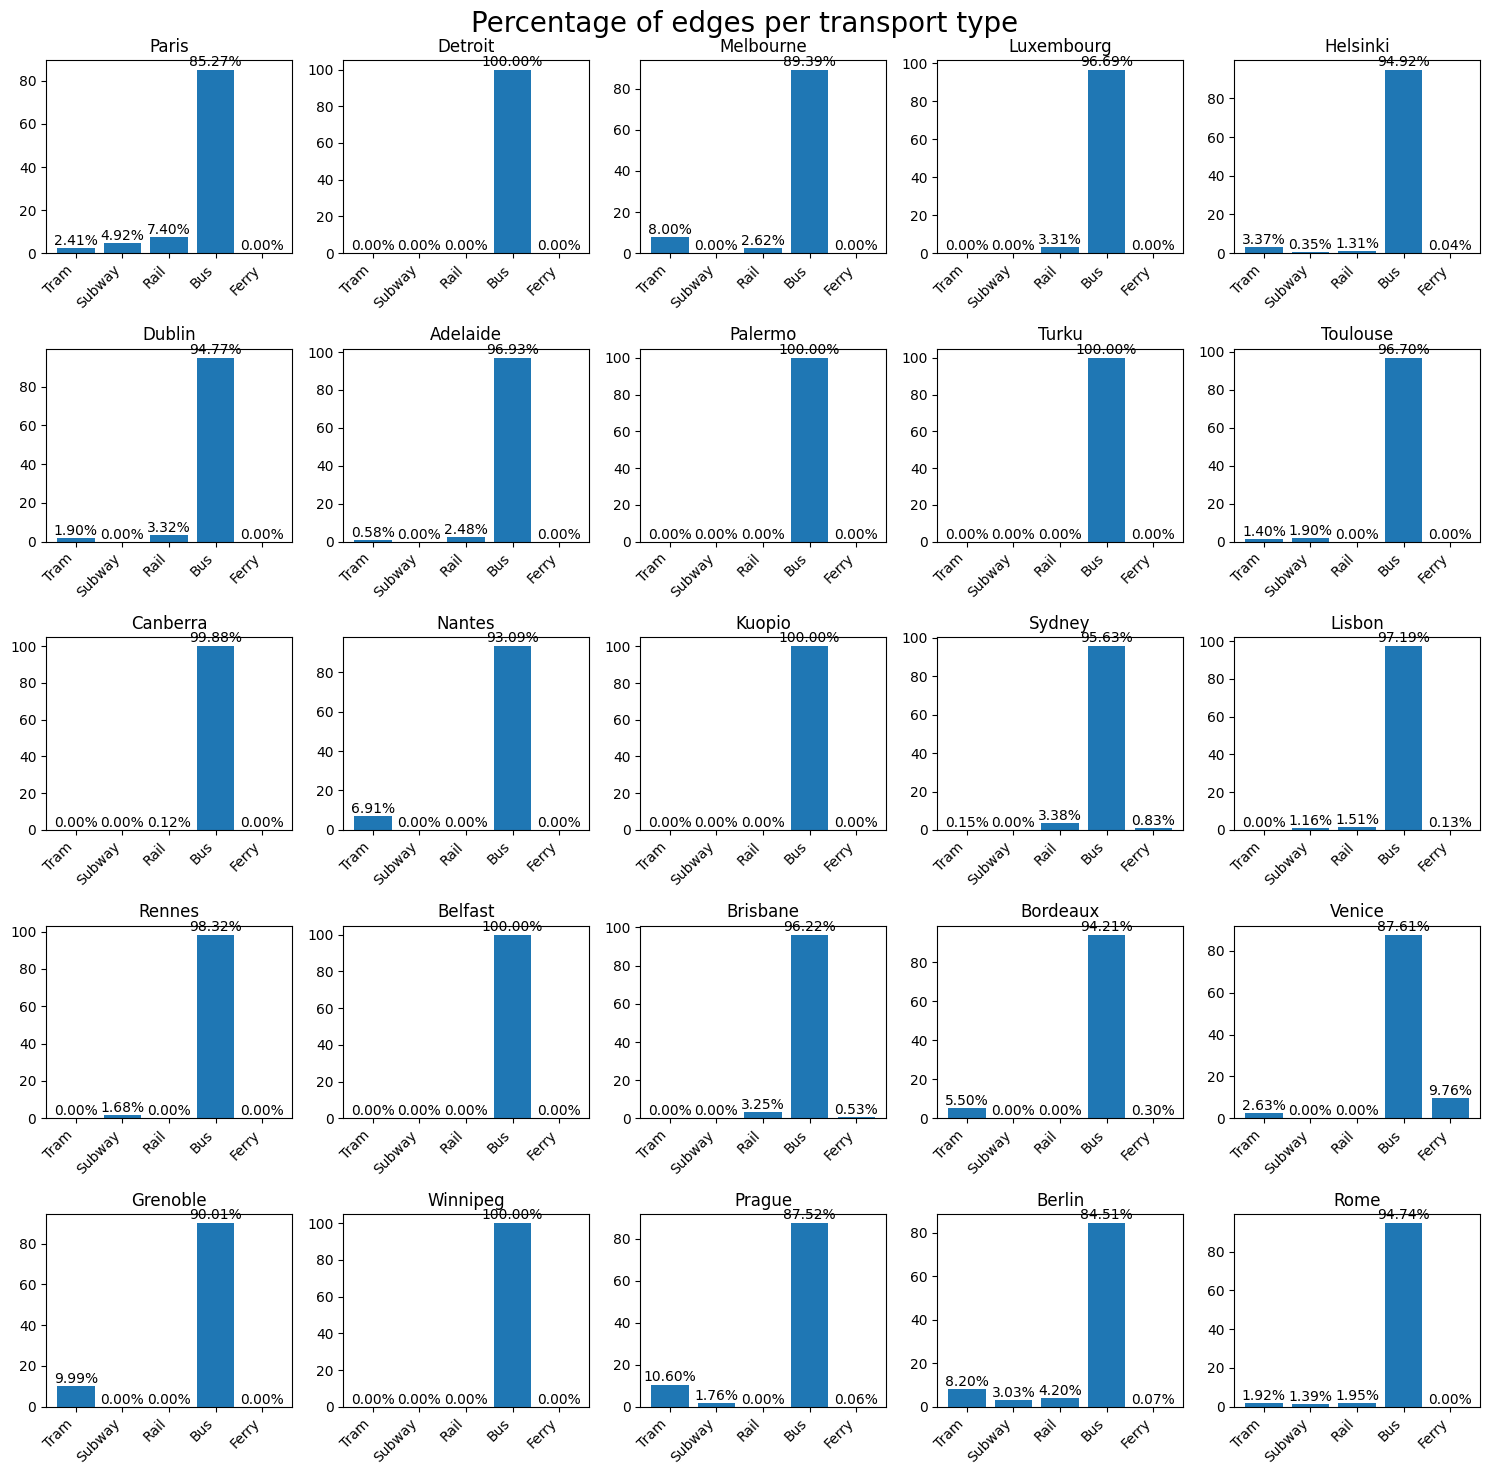

In [4]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

# Plot percentage of edges per transport type, for each city
for ax, city, graph in zip(axs.flatten(), all_cities, combined_graphs):
    plot_route_percentages(city, graph, ax)

fig.suptitle("Percentage of edges per transport type", fontsize=20)
plt.tight_layout()
plt.show()

We see that among the public transport types, the bus network is the most developped, by a good margin. Therefore, we conduct the following analysis solely on the bus network. We believe it is a good approach as
* The metrics of interest studied in class apply to simple graph (i.e. not multi-graphs)
* Considering the other transport networks separately provides little information as it connects an insignificant part of the network only.

#### Degree distribution

We begin by studying the degree distribution to determine whether the citie's networks can be approximated by models seen in class (e.g. Erdős–Rényi).

In [5]:
max_degree = max([max(g.degree(), key=lambda x: x[1])[1] for g in combined_graphs])
print("Max degree:", max_degree)

Max degree: 36


In the next cell, we plot the degree distribution for each city on a log-log scale. We compare it with a power-law with a slope that follows the distribution's trend. Moreover, we plot the PDF of a Poisson distribution, as it approximates the degree distribution of random graphs. 

The Poisson distribution is smoothed over real inputs by using the gamma function in place of the factorial when computing the Poisson PDF. We use as parameter $\mu$ the empirical average degree, as usual.

In [20]:
bus_graphs = [load_graph(city, "bus") for city in all_cities]

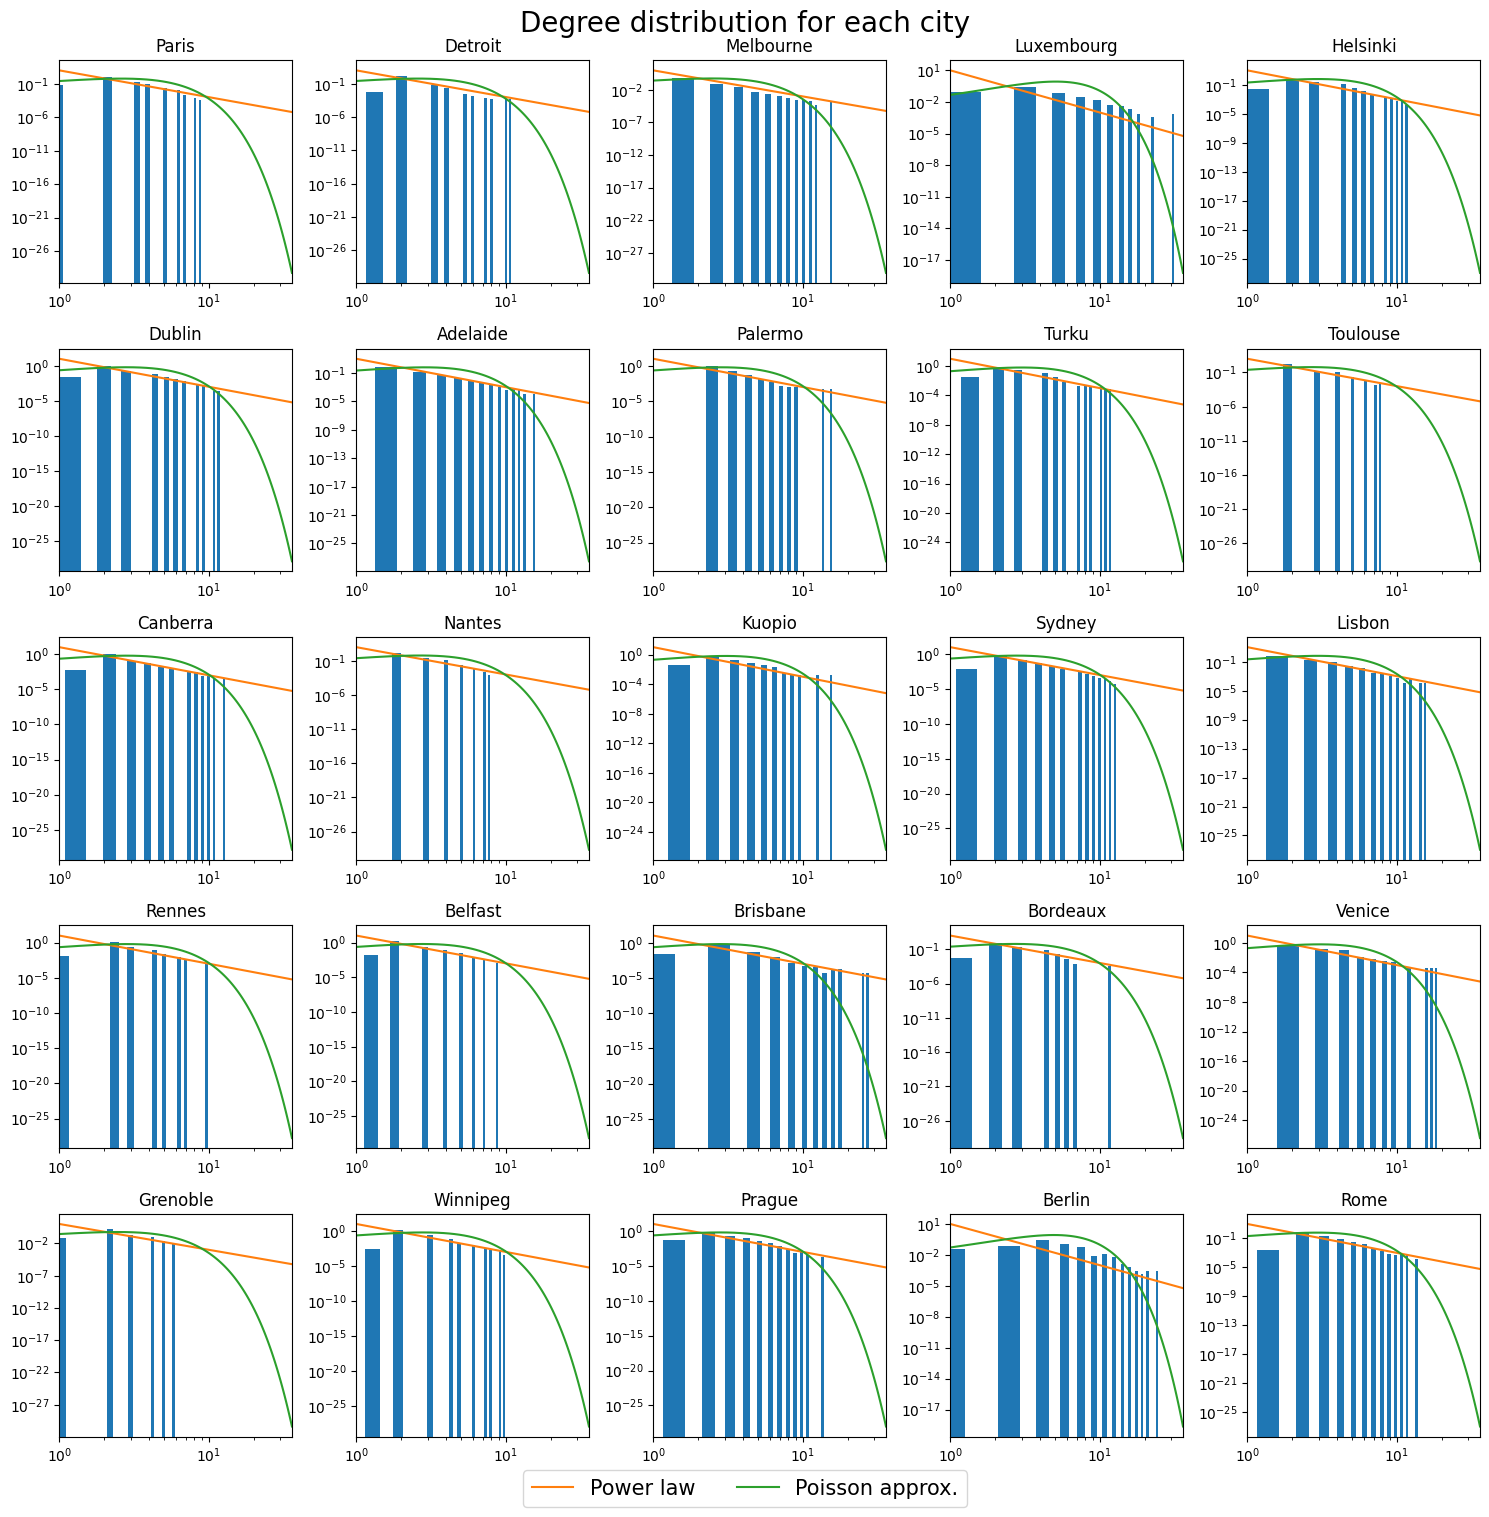

In [7]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

x = np.linspace(1, max_degree, 100)  # x values for plotting
gamma = 4  # power law exponent
C = 10
y_power_law = x ** (-gamma) * C  # power law distribution

for ax, city, graph in zip(axs.flatten(), all_cities, bus_graphs):
    ax.set_xlim(1, max_degree)
    plot_degree_distribution(city, graph, ax)
    ax.plot(x, y_power_law, label=f"Power law")

    avg_degree = graph_average_degree(graph)
    y_poisson = poisson_density(x, avg_degree)
    ax.plot(x, y_poisson, label=f"Poisson approx.")


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=15, bbox_to_anchor=(0.5, -0.025))


fig.suptitle("Degree distribution for each city", fontsize=20)
fig.tight_layout()

We see that the tail of the distribution is usually empty too quickly to be modelled by either of the distributions. The most notable exceptions are Berlin, Luxembourg and to a lesser extent Brisbane, which are significantly fatter-tailed than the other cities.

#### Sparsity

We expect the public transport network to be quite sparse, as connecting far edges without intermediate halt is inefficient:

In [41]:
for city, graph in zip(all_cities, bus_graphs):
    n_edges = graph.number_of_edges()
    n_vertices = graph.number_of_nodes()
    max_n_edges = n_vertices * (n_vertices - 1)  # Recall we have a directed graph
    print(city.capitalize(), ":")
    print("\tNum edges:", n_edges)
    print("\tMax num edges:", max_n_edges)
    print(f"\tPercentage of edges present: {n_edges / max_n_edges * 100 :.3f}")
    print("---")

Luxembourg :
	Num edges: 3127
	Max num edges: 1867322
	Percentage of edges present: 0.167
---
Grenoble :
	Num edges: 1514
	Max num edges: 2391662
	Percentage of edges present: 0.063
---
Dublin :
	Num edges: 5276
	Max num edges: 20889470
	Percentage of edges present: 0.025
---
Paris :
	Num edges: 12604
	Max num edges: 142790550
	Percentage of edges present: 0.009
---
Lisbon :
	Num edges: 8730
	Max num edges: 50020256
	Percentage of edges present: 0.017
---
Winnipeg :
	Num edges: 5846
	Max num edges: 25791162
	Percentage of edges present: 0.023
---
Adelaide :
	Num edges: 8973
	Max num edges: 56964756
	Percentage of edges present: 0.016
---
Rennes :
	Num edges: 1643
	Max num edges: 1978242
	Percentage of edges present: 0.083
---
Venice :
	Num edges: 2398
	Max num edges: 3510002
	Percentage of edges present: 0.068
---
Brisbane :
	Num edges: 11294
	Max num edges: 93016380
	Percentage of edges present: 0.012
---
Kuopio :
	Num edges: 704
	Max num edges: 300852
	Percentage of edges present: 0.

We see that the networks are indeed, **very** sparse.

We now display the public transport network of a city to visualize how sparse they actually look:

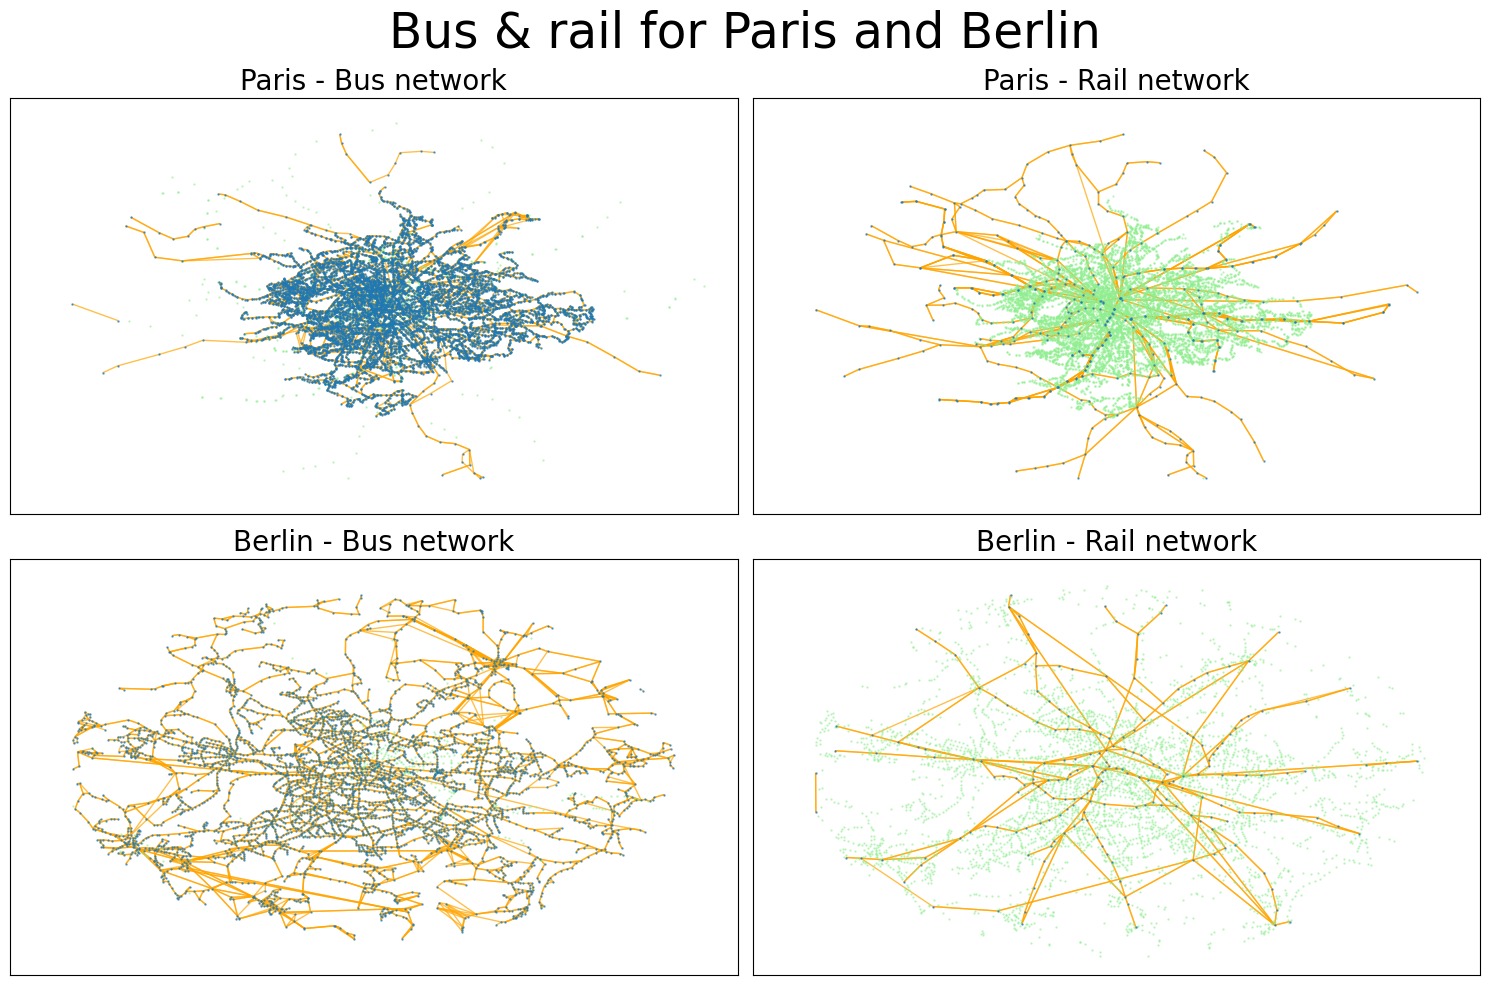

In [61]:
paris_bus = load_graph("paris", "bus")
paris_rail = load_graph("paris", "rail")

berlin_bus = load_graph("berlin", "bus")
berlin_rail = load_graph("berlin", "rail")

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

ax_fontsize = 20
suptitle_fontsize = 35

viz_graph(paris_bus, axs[0])
viz_graph(paris_rail, axs[1])
axs[0].set_title("Paris - Bus network", fontsize=ax_fontsize)
axs[1].set_title("Paris - Rail network", fontsize=ax_fontsize)

viz_graph(berlin_bus, axs[2])
viz_graph(berlin_rail, axs[3])
axs[2].set_title("Berlin - Bus network", fontsize=ax_fontsize)
axs[3].set_title("Berlin - Rail network", fontsize=ax_fontsize)

fig.suptitle("Bus & rail for Paris and Berlin", fontsize=suptitle_fontsize)
fig.tight_layout()

fig.savefig("plots/net_topology.png", dpi=300, bbox_inches="tight")


We see that Paris and Berlin's public transport networks look quite different. 

Regarding the bus network, paris has many more connections close to its geographical center while Berlin is more evenly distributed.

Regarding the rail network, it follows a star-like topology from the center for both cities.

The blue nodes have edges in the current public transport network while the green ones do not and are more transparent for better visibility. The edges are always drawn in orange.

#### Global statistics

Global statistics such as average degree, clustering coefficient and average distance are useful to determine whether one can approximate a network using some well-known model. Despite our unsuccessful experiment with the degree distribution, we nonetheless compute those statistics to make sure our earlier conclusion hold ground.

Since the computation of statistics is time-consuming, we save the values on disk for further reuse.

In [26]:
compute_statistics = False
all_statistics = {}

if compute_statistics:
    # Compute statistics for each city and save to disk
    for city, graph in tqdm(zip(all_cities, bus_graphs), desc="Computing graph statistics...", total=len(all_cities)):
        g_stats = compute_graph_main_statistics(graph)
        all_statistics[city] = g_stats
        # Save to disk
        fname = os.path.join('statistics', f"{city}.pkl")
        with open(fname, "wb") as f:
            pickle.dump(g_stats, f)

else:
    # Load statistics from disk
    for city in all_cities:
        fname = os.path.join('statistics', f"{city}.pkl")
        with open(fname, "rb") as f:
            g_stats = pickle.load(f)
            all_statistics[city] = g_stats


We now display the empirical statstics with the theoretical ones for Erdős–Rényi and Barabási–Albert model:

In [27]:
def within_half_order_of_magn(x, ref):
    upper = ref * 5
    lower = ref / 5
    return x < upper and x > lower

In [28]:
for city in all_cities:
    stats = all_statistics[city]
    print(city.capitalize(), ":")
    print(f"\tAverage degree:  {stats['avg_in_degree']:.3f}")
    print(f"\tAverage degree squared: {stats['avg_in_deg2']:.3f}")
    print(f"\tClustering coefficient: {stats['clustering_coeff']}")
    print(f"\tClustering coeff. random network: {stats['avg_in_degree'] / stats['n']}")
    print(f"\tClustering coeff. in BA networks: {np.log(stats['n']) ** 2 / stats['n'] }")
    print(f"\tValue within 1/2 OOM of BA value: {within_half_order_of_magn(stats['clustering_coeff'], np.log(stats['n']) ** 2 / stats['n'])}")
    print(f"\tValue within 1/2 OOM of random network value: {within_half_order_of_magn(stats['clustering_coeff'], stats['avg_in_degree'] / stats['n'])}")

    print()
    print(f"\tAverage distance: {stats['avg_dist']:.3f}")
    print(f"\tAverage distance in random network: {np.log(stats['n']) / np.log(stats['avg_in_degree']) :.3f}")
    print(f"\tAverage distance in BA network: {np.log(stats['n']) / np.log(np.log(stats['n']))}")
    print("---")

Paris :
	Average degree:  1.055
	Average degree squared: 1.446
	Clustering coefficient: 0.0027078435279272095
	Clustering coeff. random network: 8.826176012324714e-05
	Clustering coeff. in BA networks: 0.007376040153784351
	Value within 1/2 OOM of BA value: True
	Value within 1/2 OOM of random network value: False

	Average distance: 65.658
	Average distance in random network: 176.201
	Average distance in BA network: 4.19225416229876
---
Detroit :
	Average degree:  1.047
	Average degree squared: 1.171
	Clustering coefficient: 0.00517327104956878
	Clustering coeff. random network: 0.00018416862588376093
	Clustering coeff. in BA networks: 0.013151518612359114
	Value within 1/2 OOM of BA value: True
	Value within 1/2 OOM of random network value: False

	Average distance: 121.244
	Average distance in random network: 189.689
	Average distance in BA network: 4.0079747238349634
---
Melbourne :
	Average degree:  0.997
	Average degree squared: 1.242
	Clustering coefficient: 0.003711098597629076

We conclude that neither of the models is a good fit for our networks. See the report for more details.

Note that Melbourne has a negative expected average distance because the average degree is smaller than 1.

## Spectral analysis

For the exploitation part, we aim at clustering the graphs based on some similarity measure. The first that comes to mind is based on spectral analysis. Therefore, we present here the sorted eigenvalues of the cities to see if there is a pattern.

#### Extracting Laplacian and eigendecomposition

In [22]:
compute_spectrum = False

if compute_spectrum:
    all_spectral_values = {}
    for city, graph in tqdm(zip(all_cities, bus_graphs), desc="Extracting spectral features...", total=len(all_cities)):
        adj = symmetrize_adj(graph)
        adj = remove_deg_zero_nodes(adj)
        # Compute laplacian and eigen-decomposition
        L = compute_laplacian(adj, normalize="sym")
        lam, U = spectral_decomposition(L)

        spectral_values = {
            "symm_adj": adj,
            "L": L,
            "lam": lam,
            "U": U
        }
        all_spectral_values[city] = spectral_values
        fname = os.path.join("spectral", city + ".pkl")
        with open(fname, "wb") as f:
            pickle.dump(spectral_values, f)

else:
    all_spectral_values = {}
    for city in all_cities:
        fname = os.path.join("spectral", city + ".pkl")
        with open(fname, "rb") as f:
            spectral_values = pickle.load(f)

        all_spectral_values[city] = spectral_values

#### Plotting the sorted eigenvalues

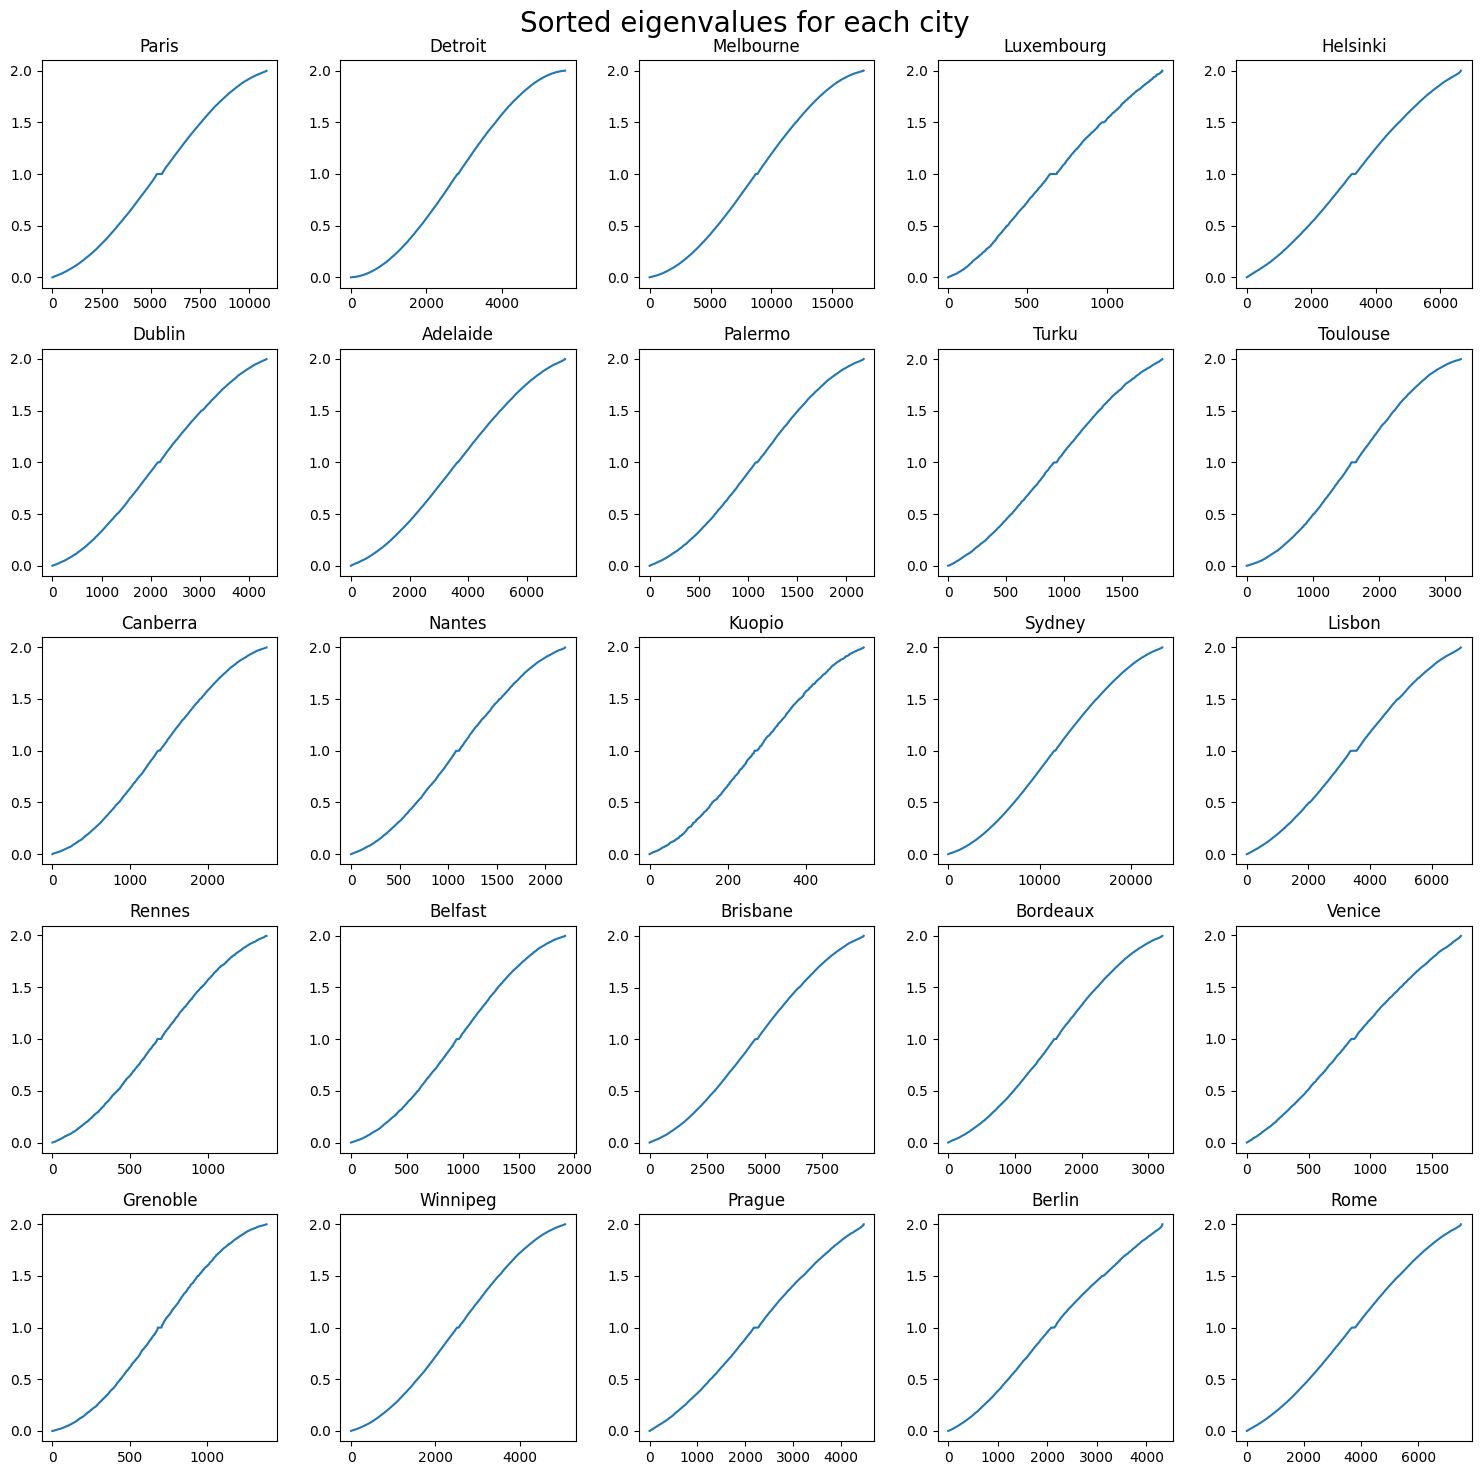

In [24]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
axs = axs.flatten()


for city, ax in zip(all_cities, axs):
    spectral_values = all_spectral_values[city]
    lam = spectral_values['lam']

    # Similar to HW3; sometimes values not correctly sorted
    lam = lam.sor
    argsort = np.argsort(lam)
    lam = lam[argsort]
    xs = np.arange(len(lam))
    ax.plot(xs, lam)
    ax.set_title(city.capitalize())

fig.suptitle("Sorted eigenvalues for each city", fontsize=20)
fig.tight_layout()

The first thing that one can see is that the plots look relatively similar and have a sigmoid-like shape.

Something that can go unnoticed due to the high number of eigenvalues, is that the lines get flat in the middle of the curve for most cities. By zooming a bit, the effect is more apparent:

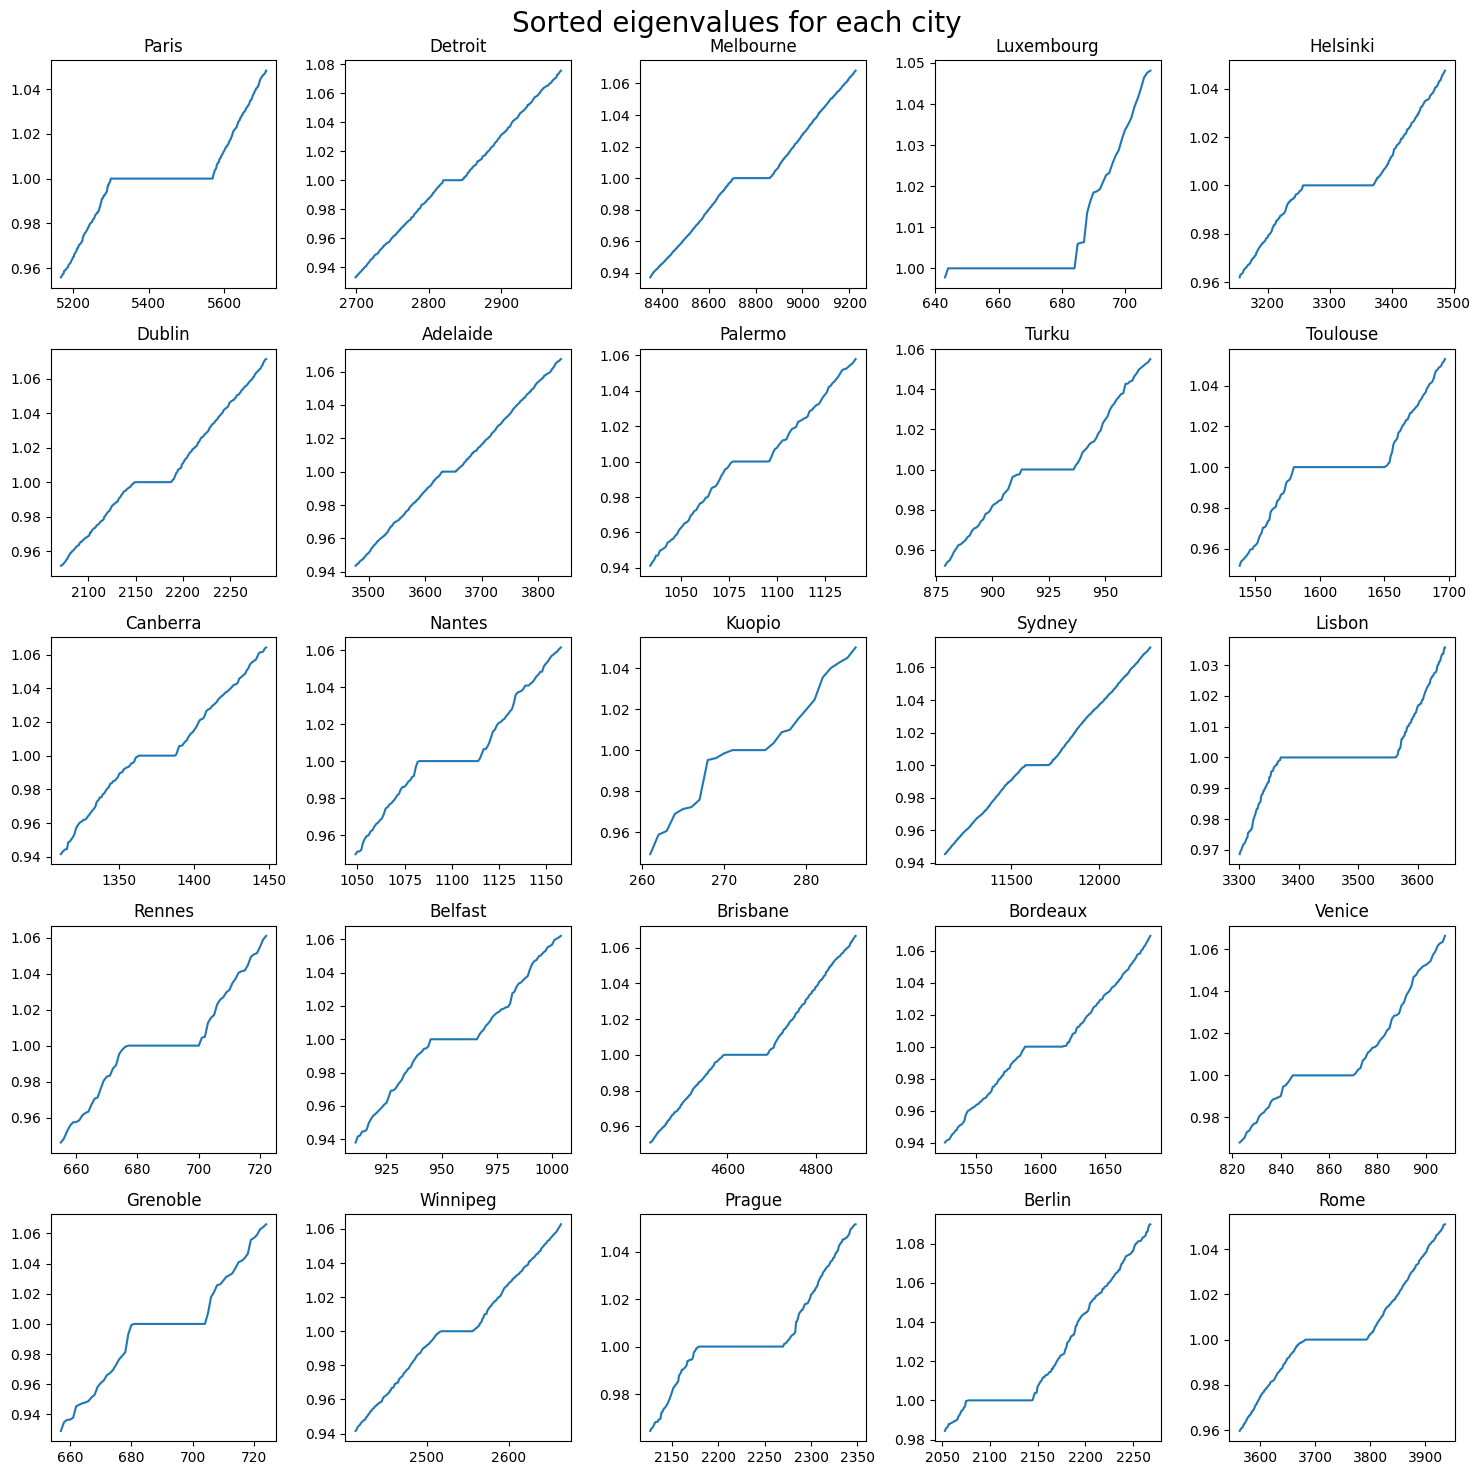

In [25]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
axs = axs.flatten()


for city, ax in zip(all_cities, axs):
    spectral_values = all_spectral_values[city]
    lam = spectral_values['lam']

    # Similar to HW3; sometimes values not correctly sorted
    argsort = np.argsort(lam)
    lam = lam[argsort]
    xs = np.arange(len(lam))
    mid = len(lam) // 2
    half_size = int(0.05 * len(lam)) // 2
    low = mid - half_size
    high = mid + half_size

    xs = xs[low:high]
    lam = lam[low:high]
    ax.plot(xs, lam)
    ax.set_title(city.capitalize())

fig.suptitle("Sorted eigenvalues for each city", fontsize=20)
fig.tight_layout()

It seems that a non-negligible portion of eigenvalues are close to 1. We are curious how many such eigenvalues there are per graph:

In [27]:
def count_close(arr, eps=1e-6):
    mask = (arr > 1 - eps) * (arr < 1 + eps)
    return np.sum(mask)

In [33]:
print("Coun the number of eigenvalues close to 1:")
for city in all_cities:
    lam = all_spectral_values[city]['lam']
    close = count_close(lam)
    print(f"\t{city.capitalize()} : {close} ({close / len(lam) * 100 :.2f}%)")

Coun the number of eigenvalues close to 1:
	Paris : 270 (2.48%)
	Detroit : 25 (0.44%)
	Melbourne : 152 (0.86%)
	Luxembourg : 41 (3.03%)
	Helsinki : 113 (1.70%)
	Dublin : 37 (0.85%)
	Adelaide : 24 (0.33%)
	Palermo : 19 (0.87%)
	Turku : 24 (1.30%)
	Toulouse : 71 (2.19%)
	Canberra : 25 (0.91%)
	Nantes : 32 (1.45%)
	Kuopio : 5 (0.91%)
	Sydney : 132 (0.56%)
	Lisbon : 194 (2.79%)
	Rennes : 24 (1.74%)
	Belfast : 22 (1.15%)
	Brisbane : 96 (1.03%)
	Bordeaux : 30 (0.93%)
	Venice : 26 (1.50%)
	Grenoble : 24 (1.74%)
	Winnipeg : 39 (0.77%)
	Prague : 90 (2.01%)
	Berlin : 67 (1.55%)
	Rome : 110 (1.47%)


Due to the slowly increasing nature of the eigenvalues, it is not immediately clear what is a good number of top eigenvectors to keep to, as opposed to the Stanford bunny example seen in homework 3, whose eigenvalues where increasing more sharply.

# Appendix

#### Edge distribution including the walk network

We mentioned earlier that when including the `walk` network with the combined one, most edges are `walk` ones. The following cell shows it.

In [52]:
all_cities = list_cities()
combined_graphs = [load_graph(city, "combined", graph_type=nx.MultiDiGraph) for city in all_cities]
walk_graphs = [load_graph(city, "walk", graph_type=nx.MultiDiGraph) for city in all_cities]
full_graphs = [nx.compose(comb_g, walk_g) for comb_g, walk_g in zip(combined_graphs, walk_graphs)]

In [53]:
full_graphs[1].edges[(1, 1342, 0)]

{'d': 310,
 'duration_avg': 44.8235294117647,
 'n_vehicles': 17,
 'route_type': -1,
 'd_walk': 311}

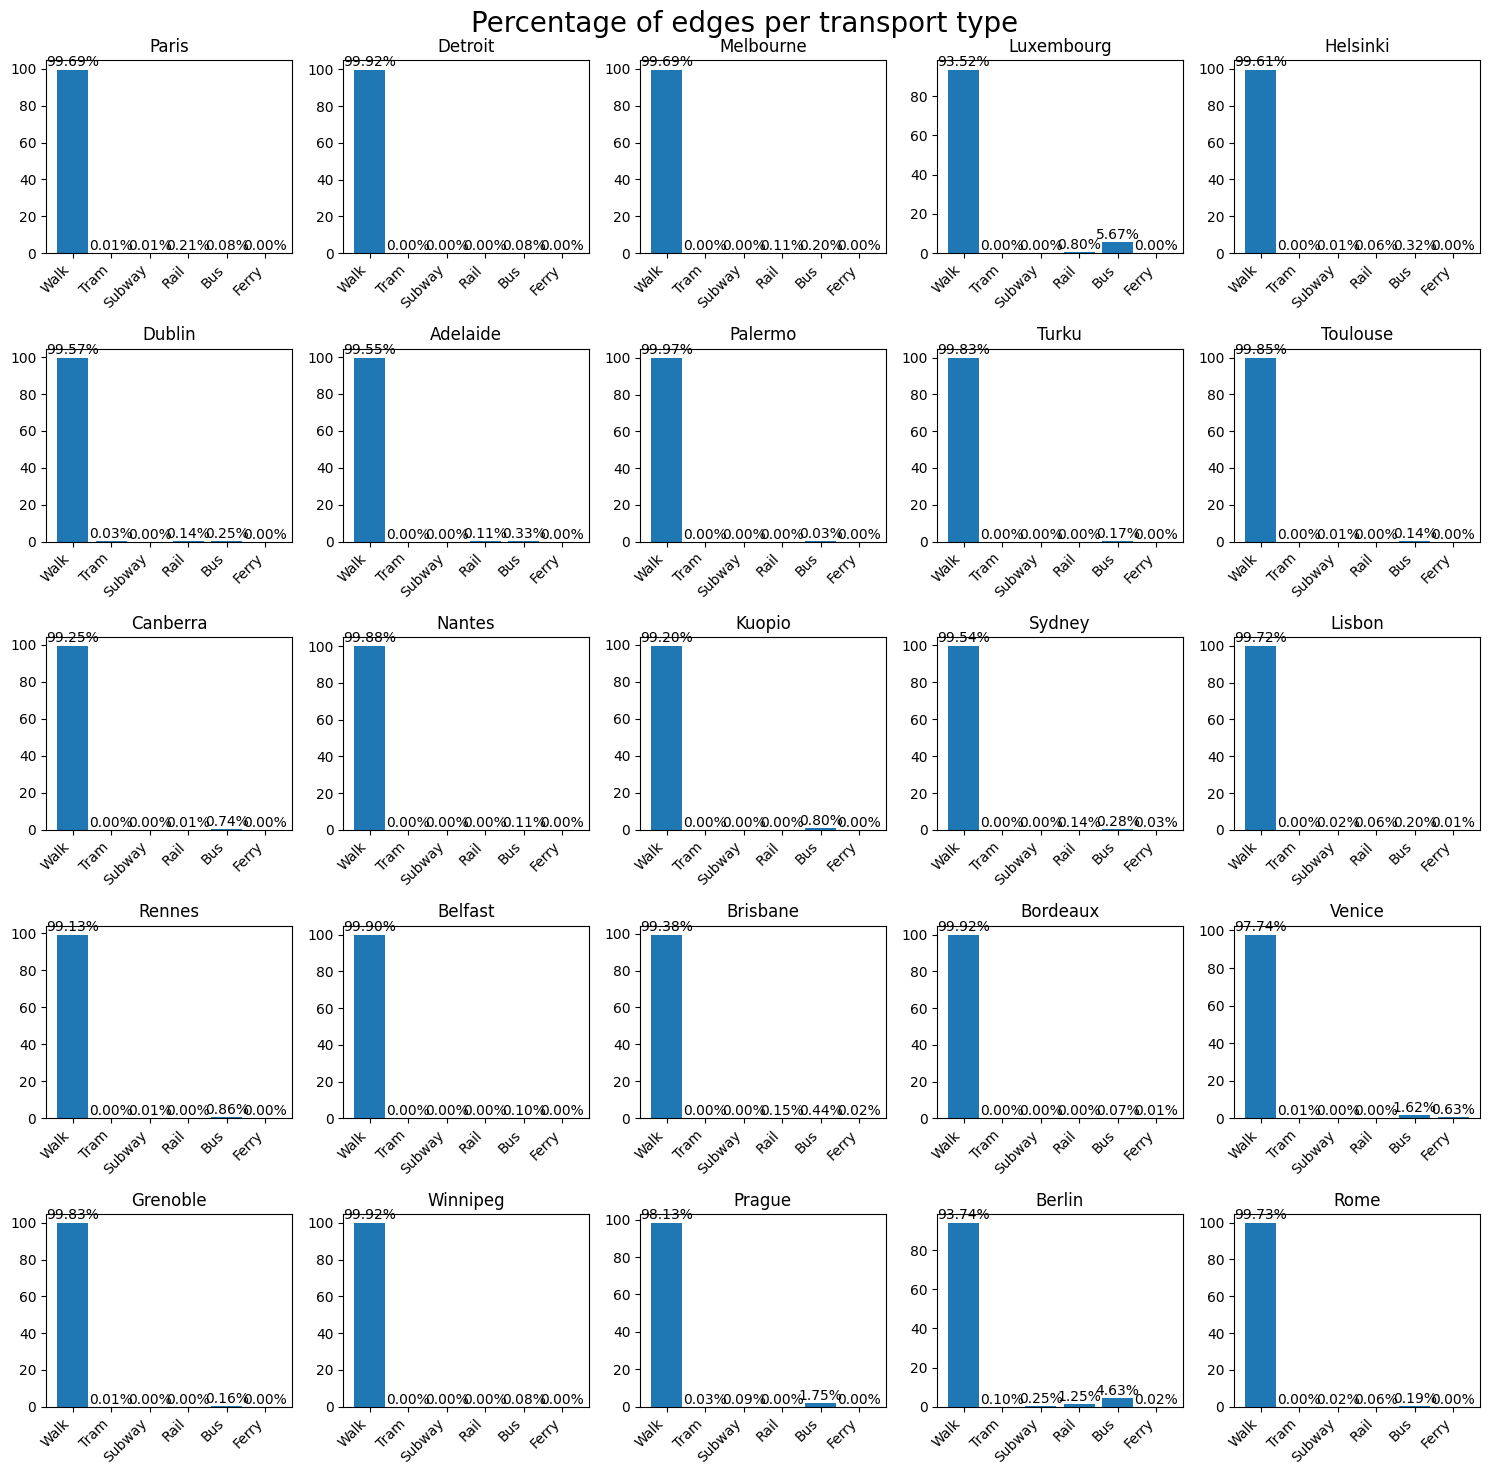

In [54]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

for ax, city, graph in zip(axs.flatten(), all_cities, full_graphs):
    plot_route_percentages(city, graph, ax, include_walk=True)

fig.suptitle("Percentage of edges per transport type", fontsize=20)
plt.tight_layout()
plt.show()

As we can see, when including the `walk` edges, the network is almost entirely composed of `walk` paths, which is undesirable since it does tell us much about the actual public transport network. Therefore, we excluded it from our main analyses.

#### Degree distribution when including the walk network

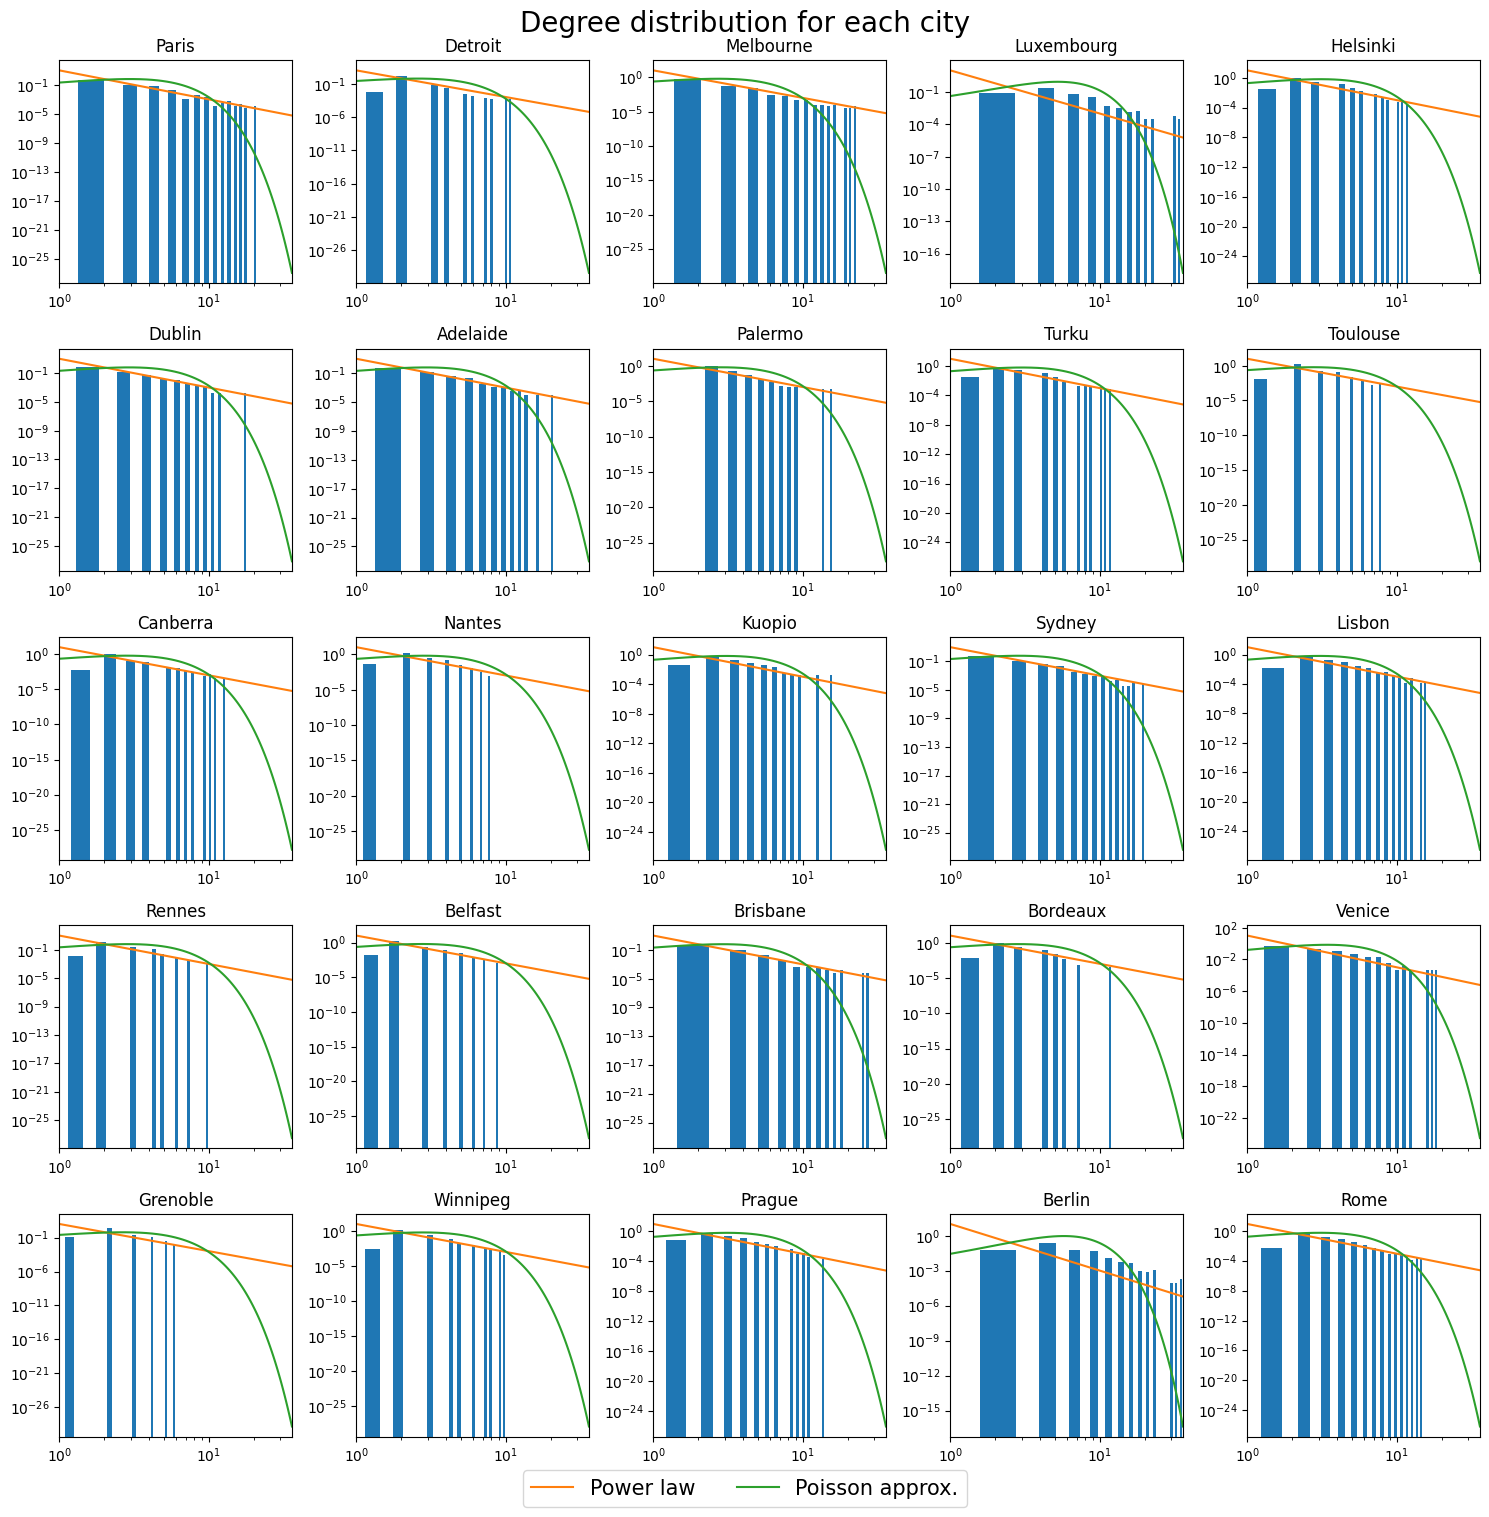

In [44]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

x = np.linspace(1, max_degree, 100)  # x values for plotting
gamma = 4  # power law exponent
C = 10
y_power_law = x ** (-gamma) * C  # power law distribution

for ax, city, graph in zip(axs.flatten(), all_cities, full_graphs):
    ax.set_xlim(1, max_degree)
    plot_degree_distribution(city, graph, ax)
    ax.plot(x, y_power_law, label=f"Power law")

    avg_degree = graph_average_degree(graph)
    y_poisson = poisson_density(x, avg_degree)
    ax.plot(x, y_poisson, label=f"Poisson approx.")


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=15, bbox_to_anchor=(0.5, -0.025))


fig.suptitle("Degree distribution for each city", fontsize=20)
fig.tight_layout()

While the exact degree distributions are different, we still see that neither of the model fits the actual data well.

#### Dealing with multi-edges

Since we deal with one network per public transport type, it might happen that in a given city, some pair of nodes have multiple edges between them. In that case, using a `DiGraph` is not suited as it does not allow multi-edges. Hopefully, `networks` offers the `MultiDiGraph` for such situation.

In the following cells, we observe that the `combined` network has multi-edges for some cities, while the `bus` and `walk` networks do not:

In [35]:
dupl = check_duplicate_route(all_cities, "combined")

print(f"There are {len(dupl)} cities with multi-edges in the combined network")

There are 8 cities with multi-edges in the combined network


In [36]:
dupl = check_duplicate_route(all_cities, "bus")
print(f"There are {len(dupl)} cities with multi-edges in the bus network")

There are 0 cities with multi-edges in the bus network


In [37]:
dupl = check_duplicate_route(all_cities, "walk")
print(f"There are {len(dupl)} cities with multi-edges in the walk network")

There are 0 cities with multi-edges in the walk network


#### Visualizing the network topologies

In [32]:
all_cities = list_cities()
walk_graphs = [load_graph(c, "walk") for c in all_cities]
combined_graphs = [load_graph(c, "combined", graph_type=nx.MultiDiGraph) for c in all_cities]

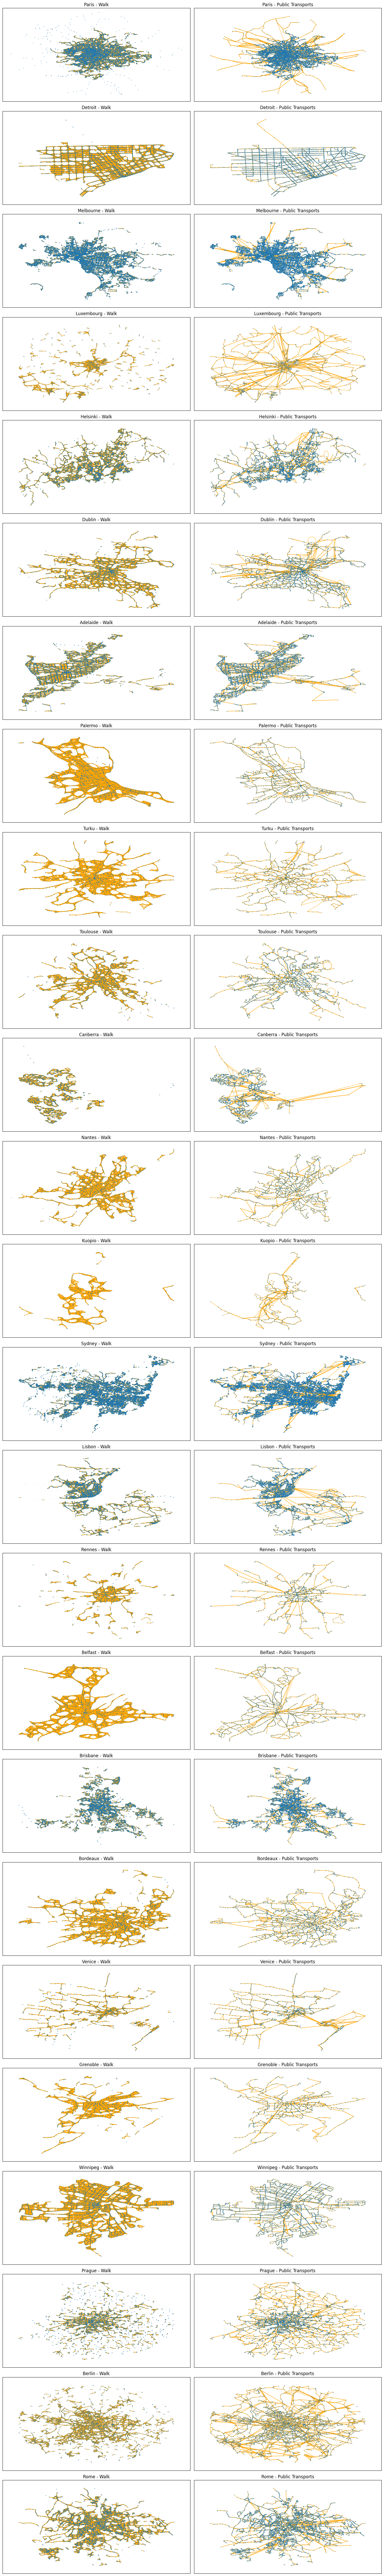

In [39]:
fig, axs = plt.subplots(25, 2, figsize=(15, 100))

for idx in range(len(all_cities)):
    city = all_cities[idx]
    viz_graph(walk_graphs[idx], axs[idx, 0])
    axs[idx, 0].set_title(f"{city.capitalize()} - Walk")

    viz_graph(combined_graphs[idx], axs[idx, 1])
    axs[idx, 1].set_title(f"{city.capitalize()} - Public Transports")
    
fig.tight_layout()

We see that the walking network is usualy disconnected and contains only very local edges. It is expected because the walking edges were manually added by the authors to account for local walking times between public transportation modes (bus, rail, etc). Therefore, it is not meant to contain all walking paths between stops, even if technically someone could decide to walk between most two stops in the city.

#### Size of the largest SCC for each city

When deciding whether to keep only the SCC to analyze the spectral properties of the graph, we concluded it would be a bad idea because it would prune too many nodes for some cities, eg Lisbon. Find below the exact number of nodes in each SCC

In [18]:
for city in list_cities():
    graph = load_graph(city, "bus")
    scc = get_largest_scc(graph)

    print(f"\t{city.capitalize()} - Perc. nodes in SCC: {scc.number_of_nodes() / graph.number_of_nodes() * 100 :.2f}% ({graph.number_of_nodes()} total num. nodes)")

	Paris - Perc. nodes in SCC: 73.06% (11950 total num. nodes)
	Detroit - Perc. nodes in SCC: 93.26% (5683 total num. nodes)
	Melbourne - Perc. nodes in SCC: 86.29% (19493 total num. nodes)
	Luxembourg - Perc. nodes in SCC: 98.39% (1367 total num. nodes)
	Helsinki - Perc. nodes in SCC: 88.25% (6986 total num. nodes)
	Dublin - Perc. nodes in SCC: 79.76% (4571 total num. nodes)
	Adelaide - Perc. nodes in SCC: 93.63% (7548 total num. nodes)
	Palermo - Perc. nodes in SCC: 100.00% (2176 total num. nodes)
	Turku - Perc. nodes in SCC: 88.27% (1850 total num. nodes)
	Toulouse - Perc. nodes in SCC: 94.38% (3329 total num. nodes)
	Canberra - Perc. nodes in SCC: 89.33% (2764 total num. nodes)
	Nantes - Perc. nodes in SCC: 87.63% (2353 total num. nodes)
	Kuopio - Perc. nodes in SCC: 81.79% (549 total num. nodes)
	Sydney - Perc. nodes in SCC: 90.48% (24063 total num. nodes)
	Lisbon - Perc. nodes in SCC: 36.34% (7073 total num. nodes)
	Rennes - Perc. nodes in SCC: 90.48% (1407 total num. nodes)
	Belfa

#### Checking for self-loops

In [67]:
all_cities = list_cities()
bus_graphs = [load_graph(city, "bus") for city in all_cities]

for city, graph in zip(all_cities, bus_graphs):
    adj = nx.adjacency_matrix(graph)
    diag = adj.diagonal()
    print(f"{city.capitalize()}'s adjacency has {diag.sum()} self-loops")

Paris's adjacency has 0 self-loops
Detroit's adjacency has 0 self-loops
Melbourne's adjacency has 0 self-loops
Luxembourg's adjacency has 0 self-loops
Helsinki's adjacency has 1 self-loops
Dublin's adjacency has 3 self-loops
Adelaide's adjacency has 13 self-loops
Palermo's adjacency has 0 self-loops
Turku's adjacency has 0 self-loops
Toulouse's adjacency has 5 self-loops
Canberra's adjacency has 0 self-loops
Nantes's adjacency has 1 self-loops
Kuopio's adjacency has 0 self-loops
Sydney's adjacency has 0 self-loops
Lisbon's adjacency has 2 self-loops
Rennes's adjacency has 0 self-loops
Belfast's adjacency has 0 self-loops
Brisbane's adjacency has 0 self-loops
Bordeaux's adjacency has 0 self-loops
Venice's adjacency has 0 self-loops
Grenoble's adjacency has 0 self-loops
Winnipeg's adjacency has 0 self-loops
Prague's adjacency has 1 self-loops
Berlin's adjacency has 1 self-loops
Rome's adjacency has 0 self-loops


#### Plots for the report

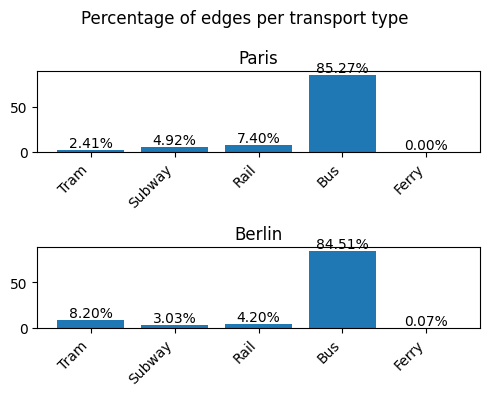

In [70]:
fig, axs = plt.subplots(2, 1, figsize=(5, 4))
axs = axs.flatten()

paris_combined = load_graph("paris", "combined", graph_type=nx.MultiDiGraph)
berlin_combined = load_graph("berlin", "combined", graph_type=nx.MultiDiGraph)

plot_route_percentages("paris", paris_combined, axs[0])
plot_route_percentages("berlin", berlin_combined, axs[1])

fig.suptitle("Percentage of edges per transport type")
fig.tight_layout()

fig.savefig("plots/edge_pt_distr", dpi=300,  bbox_inches="tight")

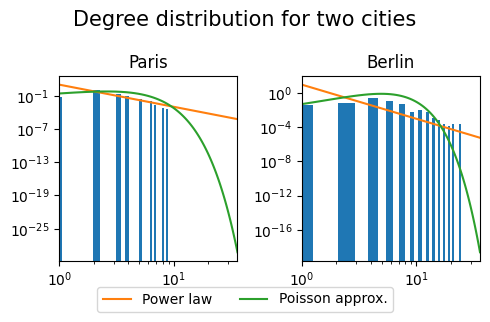

In [35]:
cities = ['paris', 'berlin']
bus_graphs = [load_graph(city, 'bus') for city in cities]
max_degree = 36

fig, axs = plt.subplots(1, 2, figsize=(5, 3))

x = np.linspace(1, max_degree, 100)  # x values for plotting
gamma = 4  # power law exponent
C = 10
y_power_law = x ** (-gamma) * C  # power law distribution

for ax, city, graph in zip(axs.flatten(), cities, bus_graphs):
    ax.set_xlim(1, max_degree)
    plot_degree_distribution(city, graph, ax)
    ax.plot(x, y_power_law, label=f"Power law")

    avg_degree = graph_average_degree(graph)
    y_poisson = poisson_density(x, avg_degree)
    ax.plot(x, y_poisson, label=f"Poisson approx.")


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=10, bbox_to_anchor=(0.5, -0.05))


fig.suptitle("Degree distribution for two cities", fontsize=15)
fig.tight_layout()

fig.savefig("plots/degree_distribution.png", dpi=300, bbox_inches='tight')

In [43]:
def center_curve_bounds(eigs_array):
    mid = len(eigs_array) // 2
    half_size = int(0.05 * len(eigs_array)) // 2
    low = mid - half_size
    high = mid + half_size

    return low, high

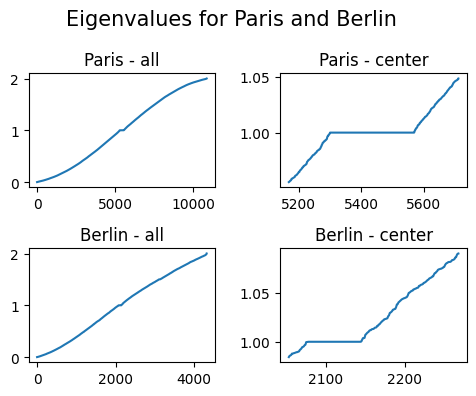

In [48]:
fig, axs = plt.subplots(2, 2, figsize=(5, 4))

paris_eigs = all_spectral_values["paris"]["lam"]
berlin_eigs = all_spectral_values["berlin"]["lam"]

paris_eigs.sort()
berlin_eigs.sort()

paris_low, paris_high = center_curve_bounds(paris_eigs)
berlin_low, berlin_high = center_curve_bounds(berlin_eigs)


axs[0, 0].plot(np.arange(len(paris_eigs)), paris_eigs)
axs[0, 0].set_title("Paris - all")
axs[0, 1].plot(np.arange(paris_low, paris_high), paris_eigs[paris_low:paris_high])
axs[0, 1].set_title("Paris - center")

axs[1, 0].plot(np.arange(len(berlin_eigs)), berlin_eigs)
axs[1, 0].set_title("Berlin - all")
axs[1, 1].plot(np.arange(berlin_low, berlin_high), berlin_eigs[berlin_low:berlin_high])
axs[1, 1].set_title("Berlin - center")

fig.suptitle("Eigenvalues for Paris and Berlin", fontsize=15)
fig.tight_layout()

fig.savefig("plots/eigvals.png", dpi=300, bbox_inches='tight')
